In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install ultralytics

In [ ]:

import os
import glob
import shutil
import random
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import yaml
import torch
from sklearn.model_selection import train_test_split
from ultralytics import YOLO

In [ ]:
print("CUDA available:", torch.cuda.is_available())

In [ ]:
base_path = "/content/drive/MyDrive/SmartVisionAI/smartvision_dataset/detection"

image_dir = os.path.join(base_path, "images")
label_dir = os.path.join(base_path, "labels")

In [ ]:
# Create train/val/test folders
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(image_dir, split), exist_ok=True)
    os.makedirs(os.path.join(label_dir, split), exist_ok=True)

In [ ]:
# Include all splits
images = sorted(glob.glob(os.path.join(image_dir, "*/*.jpg")))
labels = sorted(glob.glob(os.path.join(label_dir, "*/*.txt")))

image_names = set(os.path.splitext(os.path.basename(p))[0] for p in images)
label_names = set(os.path.splitext(os.path.basename(p))[0] for p in labels)

missing_labels = image_names - label_names
missing_images = label_names - image_names

print("Dataset integrity:", {
    "total_images": len(images),
    "total_labels": len(labels),
    "missing_labels": len(missing_labels),
    "missing_images": len(missing_images)
})


Dataset integrity: {'total_images': 2210, 'total_labels': 2210, 'missing_labels': 0, 'missing_images': 0}


In [ ]:
missing_labels = image_names - label_names
print("Images with missing labels:", missing_labels)

for img_name in missing_labels:
    # Find which split folder the image is in
    img_path_list = glob.glob(os.path.join(image_dir, "*", img_name + ".jpg"))
    for img_path in img_path_list:
        print(f"Removing image with missing label: {img_path}")
        os.remove(img_path)

Images with missing labels: set()


In [ ]:

# Refresh lists after cleanup
images = sorted(glob.glob(os.path.join(image_dir, "*/*.jpg")))
labels = sorted(glob.glob(os.path.join(label_dir, "*/*.txt")))

image_names = set(os.path.splitext(os.path.basename(p))[0] for p in images)
label_names = set(os.path.splitext(os.path.basename(p))[0] for p in labels)

missing_labels = image_names - label_names
missing_images = label_names - image_names

print("After cleanup, dataset integrity:", {
    "total_images": len(images),
    "total_labels": len(labels),
    "missing_labels": len(missing_labels),
    "missing_images": len(missing_images)
})

After cleanup, dataset integrity: {'total_images': 2210, 'total_labels': 2210, 'missing_labels': 0, 'missing_images': 0}


In [ ]:
def parse_yolo_labels(label_dir):
    records = []
    # Look into all splits
    for file in glob.glob(os.path.join(label_dir, "*/*.txt")):
        with open(file) as f:
            for line in f:
                cls, xc, yc, w, h = map(float, line.split())
                records.append({
                    "class_id": int(cls),
                    "width": w,
                    "height": h,
                    "area": w * h
                })
    return pd.DataFrame(records)

bbox_df = parse_yolo_labels(label_dir)
bbox_df.head()


,class_id,width,height,area
0,11,0.484656,0.901506,0.436920
1,11,0.508828,0.602918,0.306782
2,11,0.254922,0.494353,0.126021
3,11,0.552234,0.538588,0.297427
4,11,0.994203,0.393318,0.391038


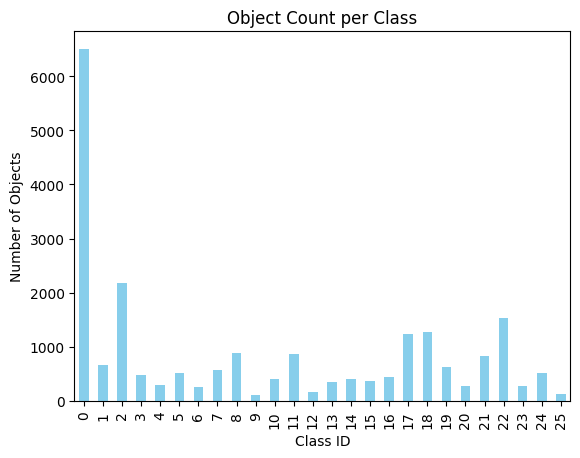

In [ ]:
bbox_df["class_id"].value_counts().sort_index().plot(kind="bar", color="skyblue")
plt.title("Object Count per Class")
plt.xlabel("Class ID")
plt.ylabel("Number of Objects")
plt.show()


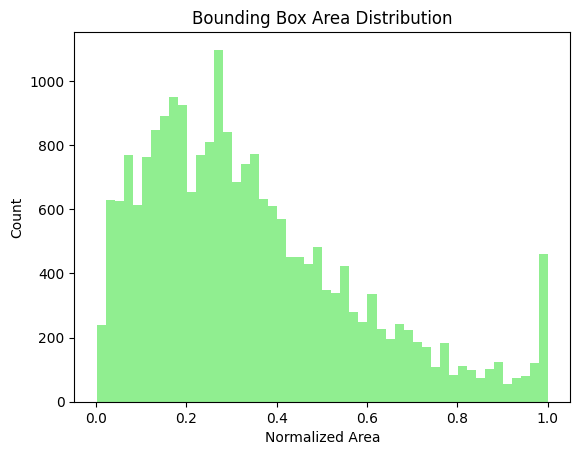

In [ ]:
plt.hist(bbox_df["area"], bins=50, color="lightgreen")
plt.title("Bounding Box Area Distribution")
plt.xlabel("Normalized Area")
plt.ylabel("Count")
plt.show()

In [ ]:
yaml_path = "/content/drive/MyDrive/SmartVisionAI/smartvision_dataset/detection/data.yaml"

with open(yaml_path, "r") as f:
    data_yaml = yaml.safe_load(f)

# Check how 'names' are stored
if isinstance(data_yaml["names"], dict):
    class_names = {int(k): v for k, v in data_yaml["names"].items()}
else:
    class_names = {i: name for i, name in enumerate(data_yaml["names"])}

num_classes = len(class_names)
print("Number of classes:", num_classes)
print(class_names)


Number of classes: 26
{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'traffic light', 9: 'stop sign', 10: 'bench', 11: 'bird', 12: 'cat', 13: 'dog', 14: 'horse', 15: 'cow', 16: 'elephant', 17: 'bottle', 18: 'cup', 19: 'bowl', 20: 'pizza', 21: 'cake', 22: 'chair', 23: 'couch', 24: 'potted plant', 25: 'bed'}


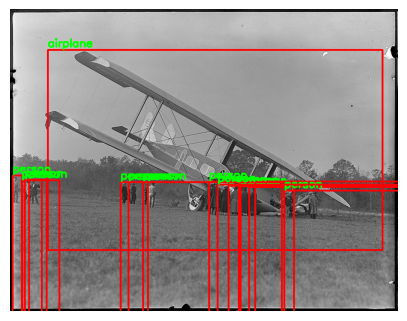

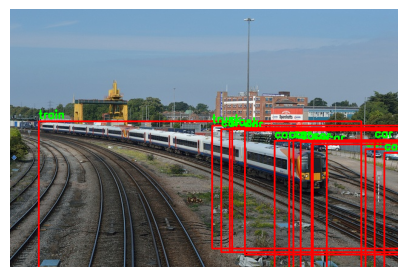

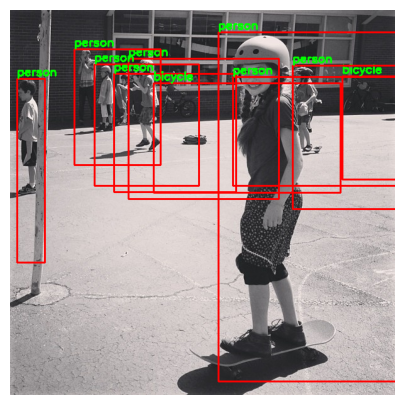

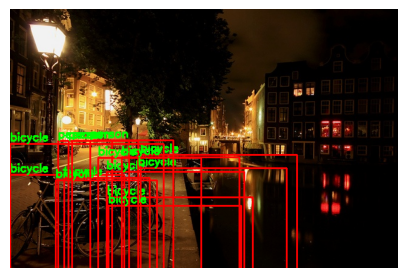

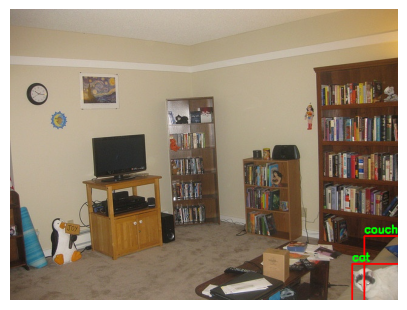

In [ ]:
def visualize_sample(n=10):
    # Include all splits
    imgs = random.sample(glob.glob(os.path.join(image_dir, "*/*.jpg")), n)

    for img_path in imgs:
        img = cv2.imread(img_path)
        h, w = img.shape[:2]

        label_path = os.path.join(
            label_dir,
            os.path.basename(os.path.dirname(img_path)),
            os.path.splitext(os.path.basename(img_path))[0] + ".txt"
        )

        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f:
                    cls, xc, yc, bw, bh = map(float, line.split())
                    cls = int(cls)

                    x1 = int((xc - bw/2) * w)
                    y1 = int((yc - bh/2) * h)
                    x2 = int((xc + bw/2) * w)
                    y2 = int((yc + bh/2) * h)

                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
                    cv2.putText(
                        img,
                        class_names[cls],
                        (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.6,
                        (0, 255, 0),
                        2
                    )

        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

visualize_sample(n=5)


In [ ]:
from ultralytics import YOLO

print("YOLO version check OK")
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


YOLO version check OK
CUDA available: False
GPU: CPU


In [ ]:
data_yaml = "/content/drive/MyDrive/SmartVisionAI/smartvision_dataset/detection/data.yaml"

with open(data_yaml) as f:
    data = yaml.safe_load(f)

In [ ]:
model = YOLO("yolov8m.pt")  # COCO-pretrained

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8m.pt")

results = model.train(
    data=data_yaml,
    epochs=50,
    imgsz=640,
    batch=16,
    optimizer="AdamW",
    lr0=0.001,
    weight_decay=0.0005,
    patience=10,
    device=0,
    workers=4,
    project="SmartVisionAI",
    name="yolov8_detection_25cls"
)


Ultralytics 8.4.8 🚀 Python-3.12.12 torch-2.9.0+cpu 


ValueError: Invalid CUDA 'device=0' requested. Use 'device=cpu' or pass valid CUDA device(s) if available, i.e. 'device=0' or 'device=0,1,2,3' for Multi-GPU.

torch.cuda.is_available(): False
torch.cuda.device_count(): 0
os.environ['CUDA_VISIBLE_DEVICES']: 0
See https://pytorch.org/get-started/locally/ for up-to-date torch install instructions if no CUDA devices are seen by torch.
